# Exploratory Data Analysis

In this notebook we will explore the dataset, aggregate statistics for fighters and generate ideas for what we would like to include in our dashboard

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('Data/UFC_dataset_clean.csv', index_col=0)
df.head()

,red_fighter,blue_fighter,red_kd,blue_kd,red_ss_pct,blue_ss_pct,red_td_pct,blue_td_pct,red_sub_att,blue_sub_att,...,blue_clinch_att,blue_clinch_landed,red_grnd_att,red_grnd_landed,blue_grnd_att,blue_grnd_landed,fight_time,title_bout,date,location
0,Jack Hermansson,Sean Strickland,0,0,0.38,0.46,0.00,0.00,0,0,...,2,2,0,0,0,0,1500,0,05-2022-02,"Las Vegas, Nevada, USA"
1,Punahele Soriano,Nick Maximov,0,0,0.71,0.64,0.00,0.68,0,1,...,10,10,23,23,4,4,900,0,05-2022-02,"Las Vegas, Nevada, USA"
2,Shavkat Rakhmonov,Carlston Harris,1,0,0.46,0.37,0.33,0.00,0,0,...,2,2,8,4,0,0,250,0,05-2022-02,"Las Vegas, Nevada, USA"
3,Sam Alvey,Brendan Allen,0,1,0.42,0.66,0.00,0.00,0,1,...,3,2,0,0,4,2,430,0,05-2022-02,"Las Vegas, Nevada, USA"
4,Tresean Gore,Bryan Battle,0,0,0.60,0.58,0.66,0.12,1,0,...,8,7,4,4,0,0,900,0,05-2022-02,"Las Vegas, Nevada, USA"


In [3]:
df.columns

Index(['red_fighter', 'blue_fighter', 'red_kd', 'blue_kd', 'red_ss_pct',
       'blue_ss_pct', 'red_td_pct', 'blue_td_pct', 'red_sub_att',
       'blue_sub_att', 'red_rev', 'blue_rev', 'red_ctrl_time',
       'blue_ctrl_time', 'result', 'method', 'round', 'time', 'event_title',
       'weight_class', 'red_ss_att', 'red_ss_landed', 'blue_ss_att',
       'blue_ss_landed', 'red_ts_att', 'red_ts_landed', 'blue_ts_att',
       'blue_ts_landed', 'red_td_att', 'red_td_landed', 'blue_td_att',
       'blue_td_landed', 'red_head_att', 'red_head_landed', 'blue_head_att',
       'blue_head_landed', 'red_body_att', 'red_body_landed', 'blue_body_att',
       'blue_body_landed', 'red_leg_att', 'red_leg_landed', 'blue_leg_att',
       'blue_leg_landed', 'red_dist_att', 'red_dist_landed', 'blue_dist_att',
       'blue_dist_landed', 'red_clinch_att', 'red_clinch_landed',
       'blue_clinch_att', 'blue_clinch_landed', 'red_grnd_att',
       'red_grnd_landed', 'blue_grnd_att', 'blue_grnd_landed', 'fight_

# Developing a class to automate various data processing tasks

Focus Areas:


*   Create dataframes that put us in a position to build an accurate fighter profile
*   Represent fighter data to make comparisons intuitive



Current capabilities


*   Ability to access historical fight data based on given fighter

Features to integrate:


*   Function to aggregate data across UFC career
*   Calculate target areas (leg, body, head) both per fight and for career
*   Create pretty table to visualize historical events (Must be user interpretable)






In [4]:
# Continue to build class to store individual fighter data

class Fighter_Data():
    ''' 
    Currently extracts each unique fighter in the database and stores individual fighter data
    for each fight, stored in a dataframe. 
    '''
    def __init__(self, name):
        data = pd.read_csv('Data/UFC_dataset_clean.csv')
        data['date'] = pd.to_datetime(data['date'], format="%d-%Y-%m")
        data = data.set_index(data['date'])

        self.name = name
        self.data = data
        self.fighter_list = list(set(list(set(self.data.red_fighter)) + list((set(self.data.blue_fighter)))))
        #print(len(self.fighter_list))
        if self.name not in self.fighter_list:
            raise Exception(f"{self.name} is not a fighter listed in the database")

        self.fight_data = self.get_fight_data()
        self.fighter_career_stats = self.career_data()
      
    def get_fight_data(self):
        mask = (self.data['red_fighter'] == self.name) | (self.data['blue_fighter'] == self.name)
        columns = ['event_title', 'date', 'location', 'title_bout', 'weight_class', 'result', 'method', 'fight_time',
                   'round']
        fighter = self.data[mask]

        # Create masks to filter fighter data
        blue_cols = [col for col in self.data.columns if 'blue' in col] + columns + ['red_fighter']
        red_cols = [col for col in self.data.columns if 'red' in col] + columns + ['blue_fighter']

        red_to_none = {col: col.replace('red_', '') for col in red_cols}
        red_to_none['blue_fighter'] = 'opponent'

        blue_to_none = {col: col.replace('blue_', '') for col in blue_cols}
        blue_to_none['red_fighter'] = 'opponent'

        blue_mask = (fighter['blue_fighter'] == self.name)
        red_mask = (fighter['red_fighter'] == self.name)

        fighter_blue = fighter.loc[blue_mask, blue_cols].rename(blue_to_none, axis=1)
        fighter_red = fighter.loc[red_mask, red_cols].rename(red_to_none, axis=1)

        fighter_df = pd.concat([fighter_blue, fighter_red]).sort_index()

        fighter_df['Win'] = np.where(fighter_df['result'] == self.name, 1, 0)
        fighter_df['Draw'] = np.where(fighter_df.result == 'D', 1, 0)
        fighter_df['Loss'] = np.where(fighter_df.result != self.name, 1, 0)
        return fighter_df
    
    def career_data(self):
        strikes = ['kd', 'ss_landed', 'ts_landed', 'head_landed', 'body_landed', 'leg_landed',
                   'dist_landed', 'clinch_landed', 'grnd_landed', 'rev', 'td_landed', 'ctrl_time', 'fight_time',
                   'Win', 'Draw', 'Loss']
        cumulative = self.fight_data.loc[:, strikes].aggregate('sum')
        return cumulative

In [159]:
dom = Fighter_Data('Robert Whittaker')

In [160]:
data = dom.fight_data

In [161]:
x = [f'{data.result[i]} via {data.method[i]}\n{data.event_title[i]}\n{data.date[i]}' for i in range(len(data))]

In [162]:
def get_headline(data, i):
    if data.Win[i] == 1:
        headline = f'{data.event_title[i]}\nWin v. {data.opponent[i].split(" ")[1]}'
    if data.Draw[i] == 1:
        headline = f'{data.event_title[i]}\nDraw v. {data.opponent[i].split(" ")[1]}'
    if data.Loss[i] == 1:
        headline = f'{data.event_title[i]}\nLoss v. {data.opponent[i].split(" ")[1]}'
    return headline
    
def get_dates(data, i):
    return data.date[i].date()

In [163]:
labels = [get_headline(data, i) for i in range(len(data))]

print(labels)

['UFC on FX\nWin v. Scott', 'UFC 160\nWin v. Smith', 'UFC Fight Night\nLoss v. McGee', 'UFC 170\nLoss v. Thompson', 'UFC Fight Night\nWin v. Rhodes', 'UFC Fight Night\nWin v. Hester', 'UFC Fight Night\nWin v. Tavares', 'UFC 193\nWin v. Hall', 'UFC 197\nWin v. Natal', 'UFC Fight Night\nWin v. Brunson', 'UFC on FOX\nWin v. Souza', 'UFC 213\nWin v. Romero', 'UFC 225\nWin v. Romero', 'UFC 243\nLoss v. Adesanya', 'UFC Fight Night\nWin v. Till', 'UFC 254\nWin v. Cannonier', 'UFC Fight Night\nWin v. Gastelum']


In [164]:
from datetime import date 

dates = [get_dates(data, i) for i in range(len(data))]
min_date = date(np.min(dates).year - 1, np.min(dates).month, np.min(dates).day)
max_date = date(np.max(dates).year + 1, np.max(dates).month, np.max(dates).day)
dates

[datetime.date(2012, 12, 14),
 datetime.date(2013, 5, 25),
 datetime.date(2013, 8, 28),
 datetime.date(2014, 2, 22),
 datetime.date(2014, 6, 28),
 datetime.date(2014, 11, 7),
 datetime.date(2015, 5, 9),
 datetime.date(2015, 11, 14),
 datetime.date(2016, 4, 23),
 datetime.date(2016, 11, 26),
 datetime.date(2017, 4, 15),
 datetime.date(2017, 7, 8),
 datetime.date(2018, 6, 9),
 datetime.date(2019, 10, 5),
 datetime.date(2020, 7, 25),
 datetime.date(2020, 10, 24),
 datetime.date(2021, 4, 17)]

In [165]:
#labels = ['{0:}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]
labels

['UFC on FX\nWin v. Scott',
 'UFC 160\nWin v. Smith',
 'UFC Fight Night\nLoss v. McGee',
 'UFC 170\nLoss v. Thompson',
 'UFC Fight Night\nWin v. Rhodes',
 'UFC Fight Night\nWin v. Hester',
 'UFC Fight Night\nWin v. Tavares',
 'UFC 193\nWin v. Hall',
 'UFC 197\nWin v. Natal',
 'UFC Fight Night\nWin v. Brunson',
 'UFC on FOX\nWin v. Souza',
 'UFC 213\nWin v. Romero',
 'UFC 225\nWin v. Romero',
 'UFC 243\nLoss v. Adesanya',
 'UFC Fight Night\nWin v. Till',
 'UFC 254\nWin v. Cannonier',
 'UFC Fight Night\nWin v. Gastelum']

Text(0.5, 1.0, 'Fighter Timeline: Robert Whittaker')

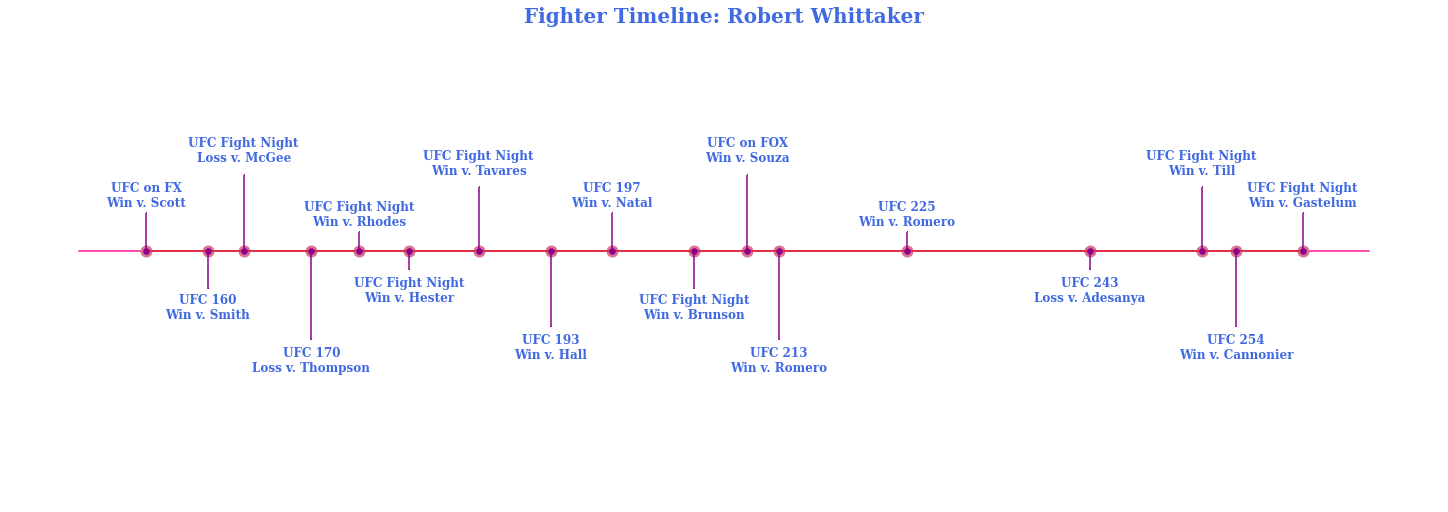

In [173]:
fig, ax = plt.subplots(figsize=(20, 7), constrained_layout=True)
_ = ax.set_ylim(-2, 1.75)
_ = ax.set_xlim(min_date, max_date)
_ = ax.axhline(0, xmin=0.05, xmax=0.95, c='deeppink', zorder=1)
 
_ = ax.scatter(dates, np.zeros(len(dates)), s=120, c='palevioletred', zorder=2)
_ = ax.scatter(dates, np.zeros(len(dates)), s=30, c='darkmagenta', zorder=3)

label_offsets = np.tile([0.35, -0.53, 0.7, -0.95, 0.2, -0.4, 0.6, -0.85], int(np.ceil(len(data)/8)))[:len(dates)]
for i, (l, d) in enumerate(zip(labels, dates)):
    _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=12)

stems = np.tile([0.3, -0.3, 0.6, -0.7, 0.15, -0.15, 0.5, -0.6], int(np.ceil(len(data)/8)))[:len(dates)]
markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
_ = plt.setp(markerline, marker=',', color='darkmagenta')
_ = plt.setp(stemline, color='darkmagenta')

# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)
#hide tick labels
_ = ax.set_xticks([])
_ = ax.set_yticks([])
ax.set_title(f'Fighter Timeline: {data.fighter[0]}',fontweight="bold", fontfamily='serif', fontsize=20, 
                 color='royalblue')

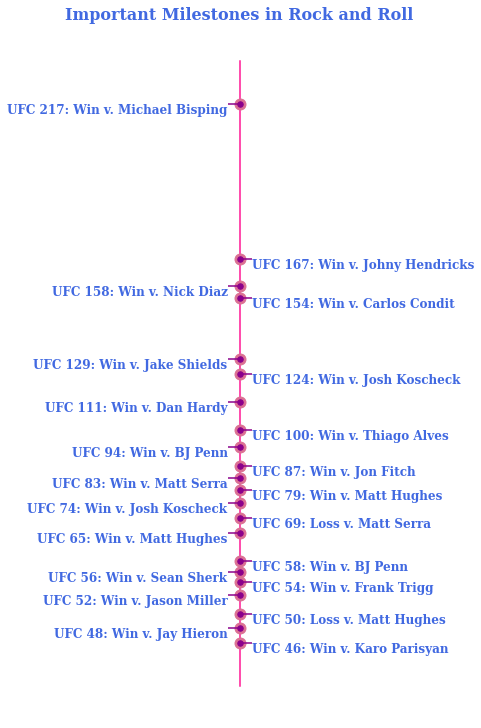

In [76]:
from datetime import timedelta

fig, ax = plt.subplots(figsize=(6, 10), constrained_layout=True)
_ = ax.set_xlim(-20, 20)
_ = ax.set_ylim(min_date, max_date)
_ = ax.axvline(0, ymin=0.05, ymax=0.95, c='deeppink', zorder=1)
 
_ = ax.scatter(np.zeros(len(dates)), dates, s=120, c='palevioletred', zorder=2)
_ = ax.scatter(np.zeros(len(dates)), dates, s=30, c='darkmagenta', zorder=3)

label_offsets = np.repeat(2.0, len(dates))
label_offsets[1::2] = -2.0
for i, (l, d) in enumerate(zip(labels, dates)):
    d = d - timedelta(days=90)
    align = 'right'
    if i % 2 == 0:
        align = 'left'
    _ = ax.text(label_offsets[i], d, l, ha=align, fontfamily='serif', fontweight='bold', color='royalblue',fontsize=12)

stems = np.repeat(2.0, len(dates))
stems[1::2] *= -1.0   
x = ax.hlines(dates, 0, stems, color='darkmagenta')

# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)
    
# hide tick labels
_ = ax.set_xticks([])
_ = ax.set_yticks([])
 
_ = ax.set_title('Important Milestones in Rock and Roll', fontweight="bold", fontfamily='serif', fontsize=16, 
                 color='royalblue')

In [ ]:
np.tile([0.3, -0.3, 0.6, -0.6], int(np.ceil(len(data)/4)))[:len(dates)]

In [ ]:
label_offsets = np.zeros(len(dates))
label_offsets[::2] = 0.35
label_offsets[1::2] = -0.7
for i, (l, d) in enumerate(zip(labels, dates)):
    _ = ax.text(d, label_offsets[i], l, ha='center', fontfamily='serif', fontweight='bold', color='royalblue',fontsize=12)


In [ ]:
stems = np.zeros(len(dates))
stems[::2] = 0.3
stems[1::2] = -0.3   
markerline, stemline, baseline = ax.stem(dates, stems, use_line_collection=True)
_ = plt.setp(markerline, marker=',', color='darkmagenta')
_ = plt.setp(stemline, color='darkmagenta')

In [ ]:
# hide lines around chart
for spine in ["left", "top", "right", "bottom"]:
    _ = ax.spines[spine].set_visible(False)
#hide tick labels
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
conor = UFC.get_fight_data('Conor McGregor')
dustin = UFC.get_fight_data('Dustin Poirier')
bobby = UFC.get_fight_data('Bobby Green')
charles = UFC.get_fight_data('Charles Oliveira')

In [ ]:
ss_pm_conor = conor.ss_landed/conor.fight_time
ss_pm_dustin = dustin.ss_landed/dustin.fight_time
ss_pm_bobby = bobby.ss_landed/bobby.fight_time
ss_pm_charles = charles.ss_landed/charles.fight_time

plt.figure(figsize=(10,7))
plt.scatter(conor.index, ss_pm_conor, color='green', label='Conor McGregor')
plt.scatter(dustin.index, ss_pm_dustin, color='blue', label='Dustin Poirier')
plt.scatter(bobby.index, ss_pm_bobby, color='red', label='Bobby Green')
plt.scatter(charles.index, ss_pm_charles, color='gold', label='Charles Oliveira')
plt.legend()
plt.show()


In [ ]:
1/dustin.fight_time

In [ ]:
def fighter_data(data, name):

    mask = (data['red_fighter']==name) | (data['blue_fighter']==name)
    fighter = data[mask]

    # Create masks to filter fighter data
    blue_cols = [col for col in data.columns if 'blue' in col] + ['red_fighter']
    red_cols = [col for col in data.columns if 'red' in col] + ['blue_fighter']

    red_to_none = {col:col.replace('red_', '') for col in red_cols}
    red_to_none['blue_fighter'] = 'opponent'
    blue_to_none = {col:col.replace('blue_', '') for col in blue_cols}
    red_to_none['red_fighter'] = 'opponent'

    blue_mask = (fighter['blue_fighter']==name) 
    red_mask = (fighter['red_fighter']==name) 

    fighter_blue = fighter.loc[blue_mask, blue_cols].rename(blue_to_none, axis=1)
    fighter_red = fighter.loc[red_mask, red_cols].rename(red_to_none, axis=1)

    fighter_final = pd.concat([fighter_blue, fighter_red]).sort_index()
    return fighter_final

In [ ]:
conor

In [ ]:
mask = (df['red_fighter']=='Israel Adesanya') | (df['blue_fighter']=='Israel Adesanya')

izzy = df[mask]

In [ ]:
blue_cols = [col for col in izzy.columns if 'blue' in col]
red_cols = [col for col in izzy.columns if 'red' in col]

red_to_none = {col:col.replace('red_', '') for col in red_cols}
blue_to_none = {col:col.replace('blue_', '') for col in blue_cols}

In [ ]:
blue_mask = (df['blue_fighter']=='Israel Adesanya') 
red_mask = (df['red_fighter']=='Israel Adesanya')

In [ ]:
izzy_blue = izzy.loc[blue_mask, blue_cols]
izzy_red = izzy.loc[red_mask, red_cols]

izzy_blue = izzy_blue.rename(blue_to_none, axis=1)
izzy_red = izzy_red.rename(red_to_none, axis=1)

In [ ]:
pd.concat([izzy_blue, izzy_red]).sort_index()

In [ ]:
# reference: https://mentalitch.com/key-events-in-rock-and-roll-history/
dates = [date(1954, 7, 19), date(1959, 2, 3), date(1964, 2, 9), date(1965, 7, 25), date(1967, 6, 1), date(1969, 8, 15)]
min_date = date(np.min(dates).year - 2, np.min(dates).month, np.min(dates).day)
max_date = date(np.max(dates).year + 2, np.max(dates).month, np.max(dates).day)
 
labels = ['Elvis appears on\nthe Ed Sullivan Show', 'Buddy Holly dies', 'The Beatles appear\non the Ed Sullivan Show', 
          'Bob Dylan goes electric', 'The Beatles release\nSgt. Pepper', 'Woodstock']
# labels with associated dates
labels = ['{0:%d %b %Y}:\n{1}'.format(d, l) for l, d in zip (labels, dates)]